# Final Project
## Members
#### - Michael Conner
#### - Jackson Rolando
#### - Ryan Kruk
## Dataset
#### - Space Titanic - https://www.kaggle.com/competitions/spaceship-titanic/data
## Research Question
#### - Predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly using a set of personal records recovered from the ship's damaged computer system.
## Hypothesis

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./train.csv')
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


- We could either bucket the ages or have them put as continuous
- We could have another variable for stuff like "used_room_service", "used_food_court", or bucket those columns as well

### Data Preprocessing

In [3]:
train = df.copy()

Split Passenger ID into the group and number within that group.

In [4]:
passenger_ids = train.PassengerId
group, num = zip(*[pid.split('_') for pid in passenger_ids])
train['PassengerGroup'] = group
train['PassengerNum'] = num

Split Cabin into the deck, number, and side.

In [5]:
cabins = train.Cabin
deck, num, side = zip(*[cabin.split('/') if type(cabin) != float else (cabin, cabin, cabin) for cabin in cabins])
train['CabinDeck'] = deck
train['CabinNum'] = num
train['CabinSide'] = side

Split Name into first and last name.

In [6]:
names = train.Name
first, last = zip(*[name.split(' ') if type(name) != float else (name, name) for name in names])
train['FirstName'] = first
train['LastName'] = last

In [7]:
categorical_columns = [
    'HomePlanet', 
    'CryoSleep', 
    #'Cabin', 
    'Destination', 
    'VIP', 
    'CabinDeck', 
    'CabinSide', 
    'CabinNum',
    'PassengerGroup',
    'LastName'
    ]

In [8]:
train['HomePlanet'] = train['HomePlanet'].fillna('Unknown')
train['CryoSleep'] = train['CryoSleep'].fillna(False)
train['Destination'] = train['Destination'].fillna('TRAPPIST-1e')
train['VIP'] = train['VIP'].fillna('False')

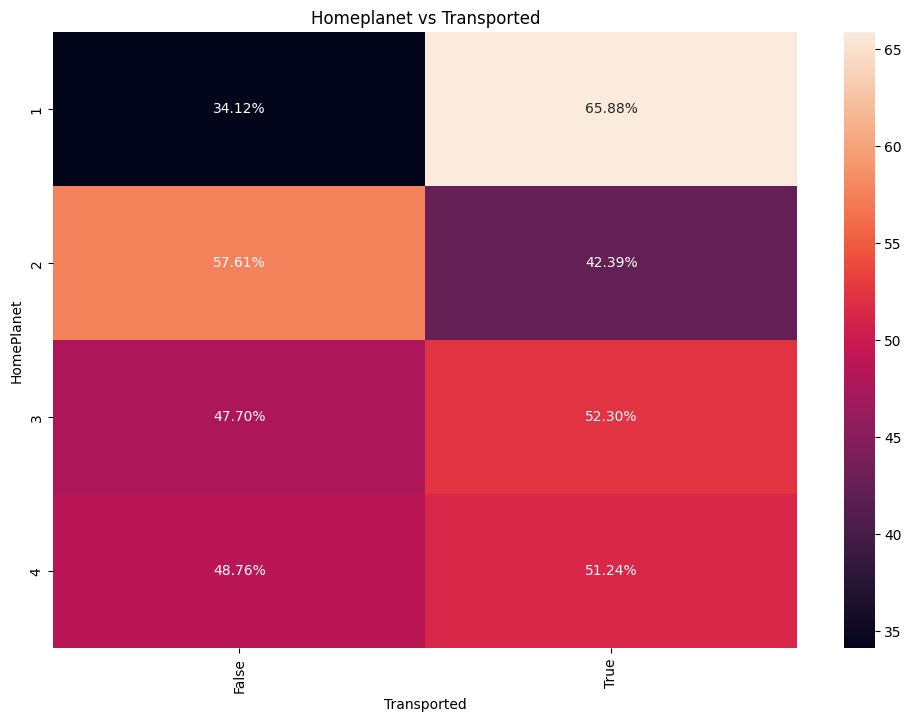

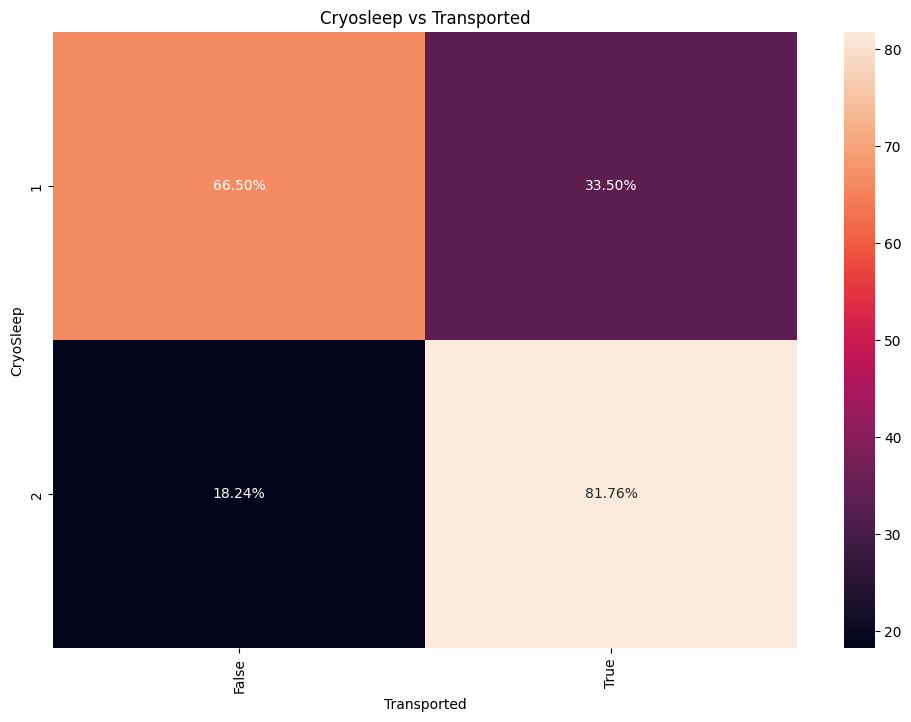

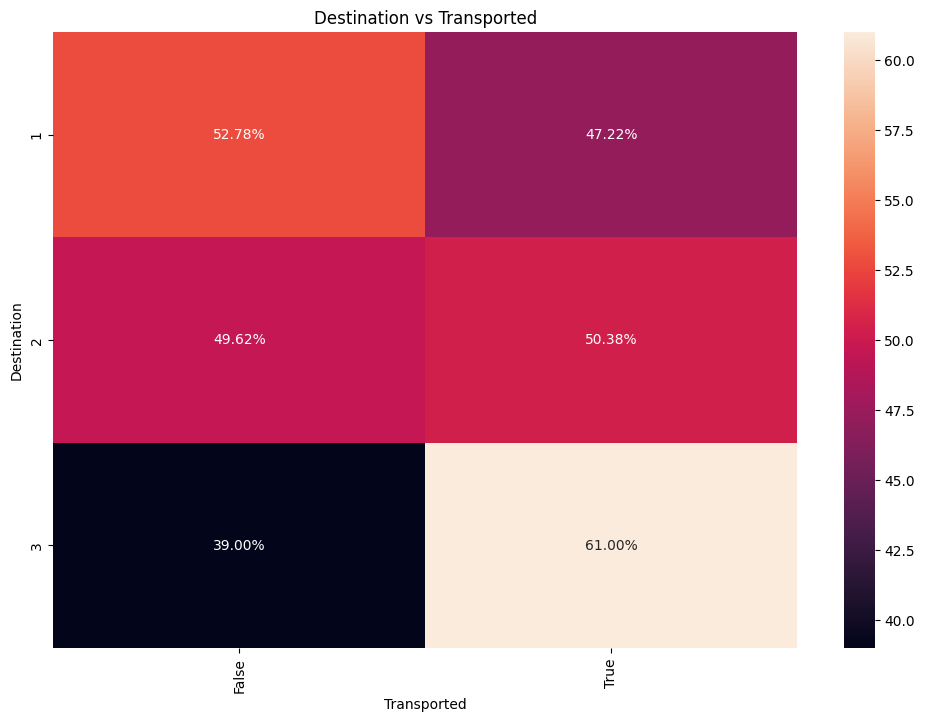

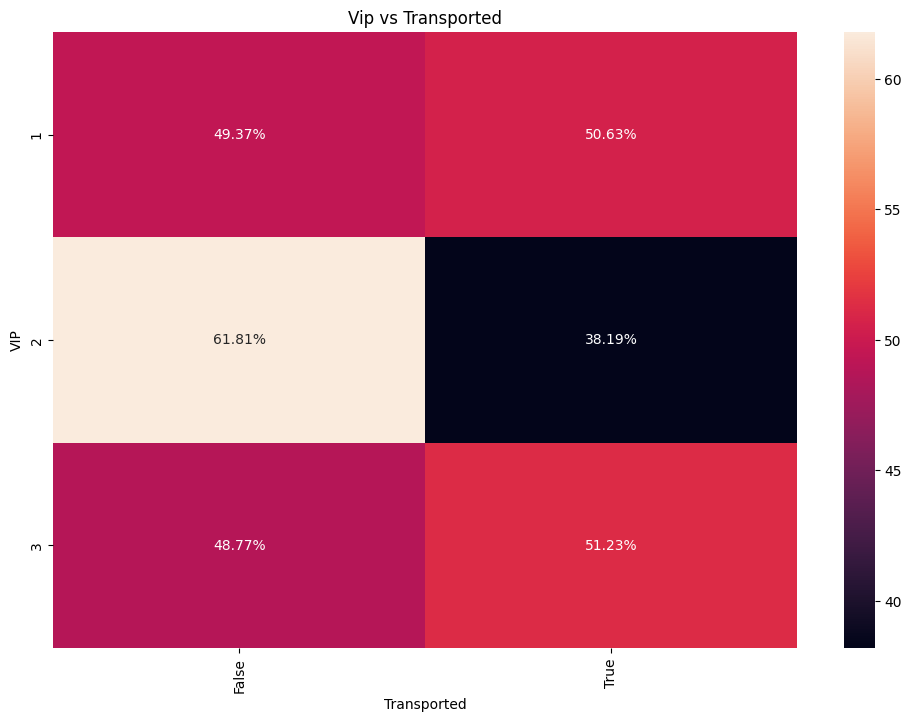

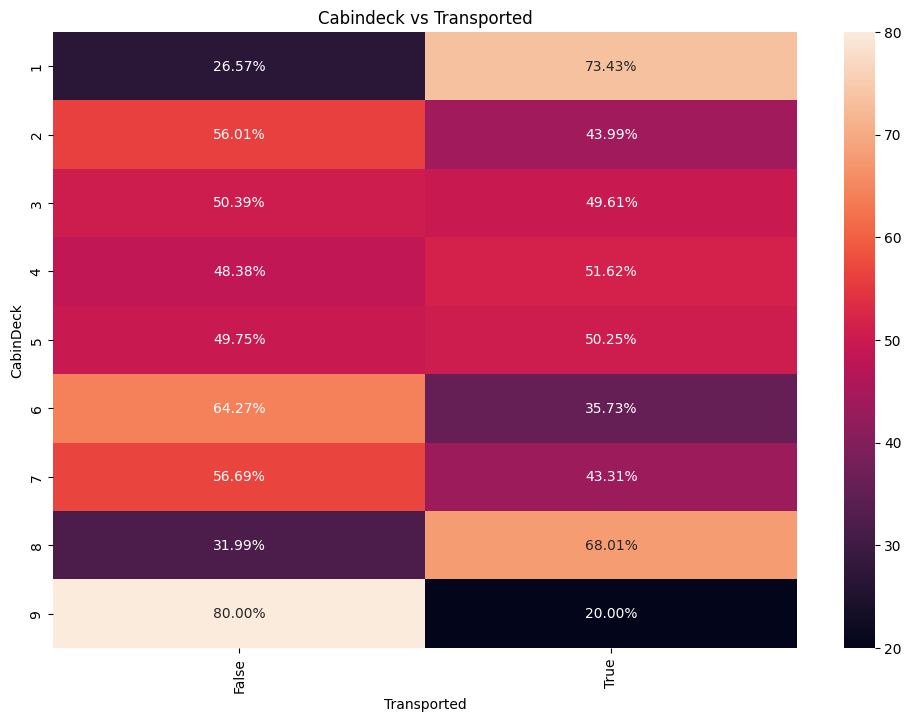

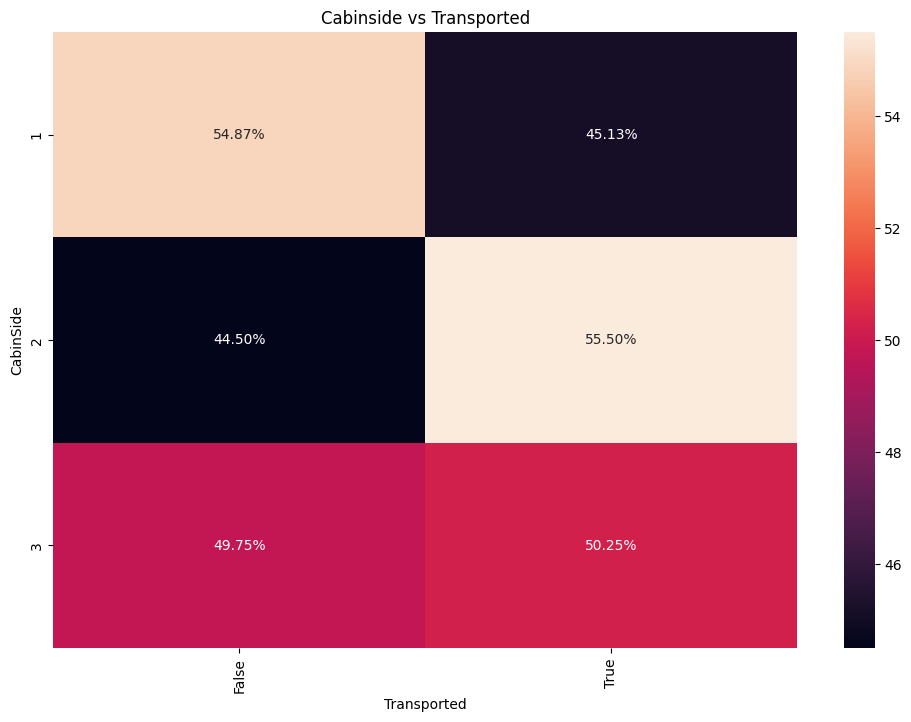

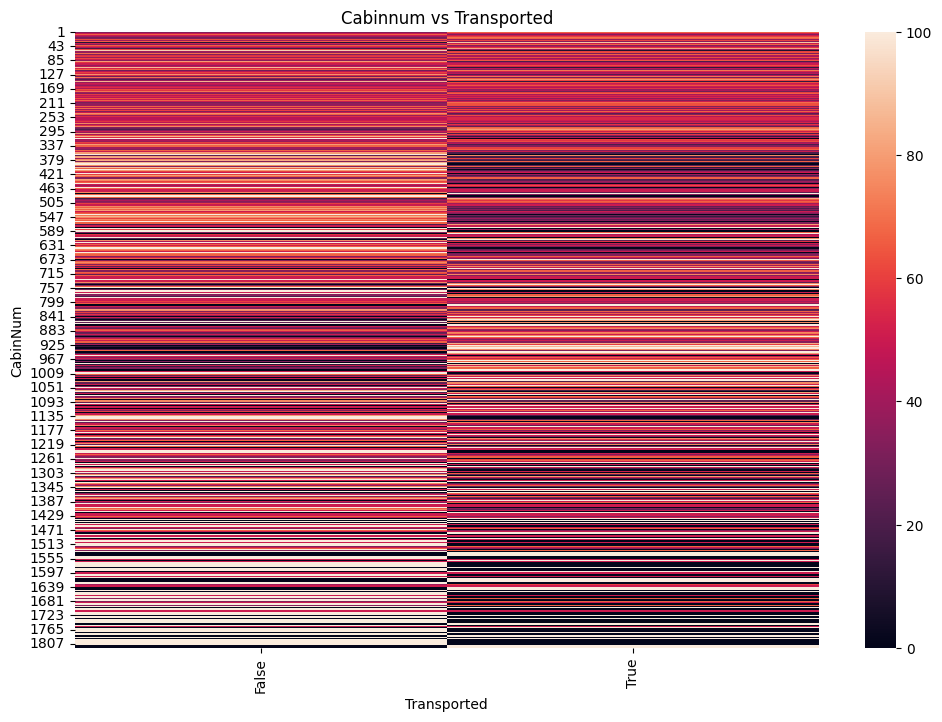

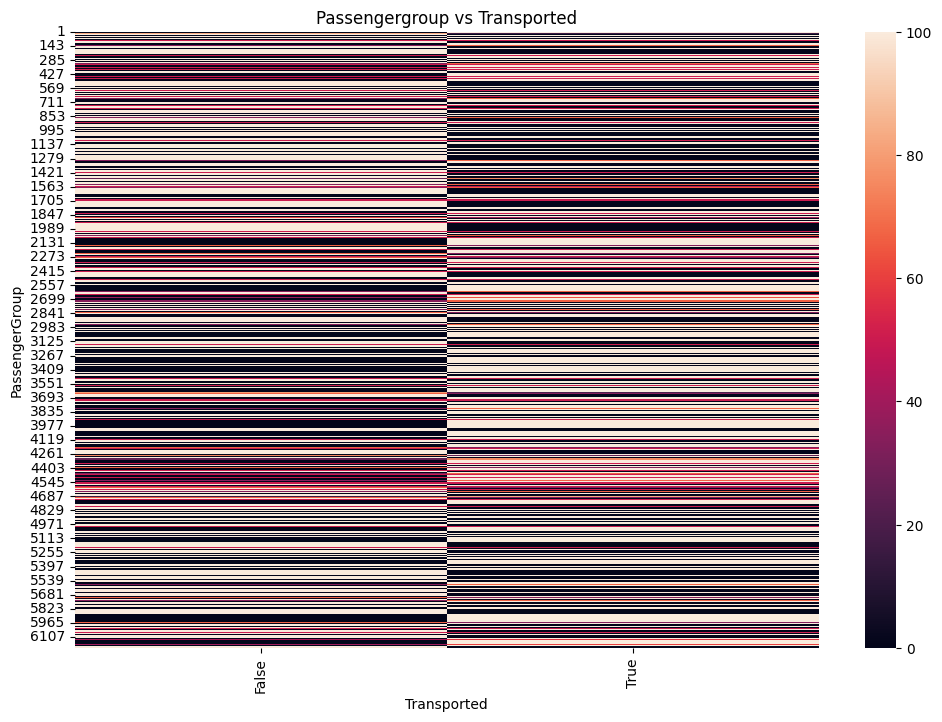

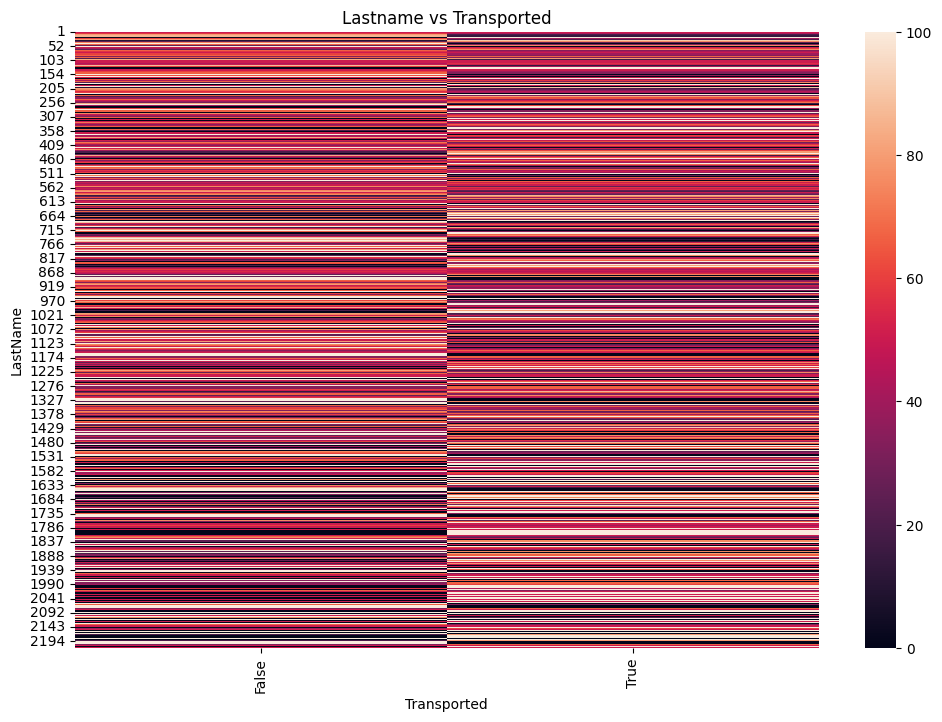

HomePlanet - chi2: 324.96723663979583, p: 3.9214919240932375e-70, significant: True
CryoSleep - chi2: 1838.5677340571679, p: 0.0, significant: True
Destination - chi2: 105.562974347811, p: 1.1947894351444843e-23, significant: True
VIP - chi2: 12.097471507075118, p: 0.0023608448102931494, significant: True
CabinDeck - chi2: 392.28874977810955, p: 8.352488438720223e-80, significant: True
CabinSide - chi2: 91.4751934343287, p: 1.3690336728997437e-20, significant: True
CabinNum - chi2: 1996.3768675081371, p: 0.0019022803659209059, significant: True
PassengerGroup - chi2: 6494.108319206162, p: 0.006870372304261477, significant: False
LastName - chi2: 2541.711051955721, p: 1.5304022522886687e-06, significant: True


In [26]:
def convert_to_percentages(row):
    return 100*row / row.sum()
for col in categorical_columns:    
    df_to_show = train.value_counts(subset=["Transported", col]).unstack(level=0).fillna(0)
    df_to_show = df_to_show.apply(convert_to_percentages, axis=1)
    plt.figure(figsize=(12, 8))
    if(df_to_show.shape[0] > 50):
        ax = sns.heatmap(df_to_show)
    else:
        ax = sns.heatmap(df_to_show, annot=True, fmt=".2f")
        for t in ax.texts: t.set_text(t.get_text() + "%")
    ax.set_title(col.capitalize() + " vs Transported")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.show()
for col in categorical_columns:
    combination_counts = train[["Transported", col]].groupby(by=["Transported", col]).size().unstack(level=0, fill_value=0)
    chi2, p, _, _ = stats.chi2_contingency(combination_counts)
    print(col + " - chi2: " + str(chi2) + ", p: " + str(p) + ", significant: " + str(p < 0.005))

The distribution of transported vs not transported seems to vary significantly across all of the columns, including VIP status. Cabin has the highest p-value, and even its distributions qualify as statistically significant with respect to a p-value of 0.01. When the cabin was split into its containing pieces though, each of them performed better than just the cabin itself. Cabin deck has the lowest p-value, meaning the distributions of transported vs not transported differed across cabin decks. This, along with most of the other columns, seem like they could prove great for prediction. 

In [10]:
categories_to_int = {
    cat: {val:i+1 for i,val in enumerate(train[cat].unique())} for cat in categorical_columns
}
int_to_categories = {
    cat: {i+1:val for i,val in enumerate(train[cat].unique())} for cat in categorical_columns
}

In [11]:
for cat in categorical_columns:
    train[cat] = train[cat].apply(lambda x: categories_to_int[cat][x])

In [12]:
ohe_arrs = {}
for cat in categorical_columns:
    ohe_arrs[cat] = np.eye(train[cat].unique().shape[0]+1)[train[cat].to_numpy()]

In [13]:
continuous_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [14]:
for col in continuous_columns:
    train[col].fillna(0)
    train[col] = train[col]/train[col].max()

In [15]:
samples = np.hstack([
    np.hstack([ohe_arrs[cat] for cat in categorical_columns]),
    np.hstack([np.expand_dims(np.nan_to_num(train[col]), axis=1) for col in continuous_columns])
])
labels = np.eye(2)[train['Transported'].astype(int)]
labels = train['Transported'].astype(int).to_numpy()

#### Make a Model

In [16]:
samples.shape

(8693, 10292)

In [17]:
dropout = 0.5
inputs = tf.keras.layers.Input(samples.shape[1], dtype=float)
x = tf.keras.layers.Dense(512, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=tf.keras.metrics.BinaryAccuracy()
)

#### Train it

In [18]:
model.fit(x=samples, y=labels, batch_size=4, epochs=4, validation_split=0.05)

Epoch 1/4
2174/2174 [==============================] - 23s 10ms/step - loss: 0.5474 - binary_accuracy: 0.7147
Epoch 2/4
2174/2174 [==============================] - 21s 10ms/step - loss: 0.3775 - binary_accuracy: 0.8325
Epoch 3/4
2174/2174 [==============================] - 22s 10ms/step - loss: 0.2239 - binary_accuracy: 0.9165
Epoch 4/4
2174/2174 [==============================] - 24s 11ms/step - loss: 0.1443 - binary_accuracy: 0.9503


#### Inference

In [19]:
df = pd.read_csv('./test.csv')
test = df.copy()
passenger_ids = test.PassengerId
group, num = zip(*[pid.split('_') for pid in passenger_ids])
test['PassengerGroup'] = group
test['PassengerNum'] = num
cabins = test.Cabin
deck, num, side = zip(*[cabin.split('/') if type(cabin) != float else (cabin, cabin, cabin) for cabin in cabins])
test['CabinDeck'] = deck
test['CabinNum'] = num
test['CabinSide'] = side
names = test.Name
first, last = zip(*[name.split(' ') if type(name) != float else (name, name) for name in names])
test['FirstName'] = first
test['LastName'] = last
test['HomePlanet'] = test['HomePlanet'].fillna('Unknown')
test['CryoSleep'] = test['CryoSleep'].fillna(False)
test['Destination'] = test['Destination'].fillna('TRAPPIST-1e')
test['VIP'] = test['VIP'].fillna('False')
for cat in categorical_columns:
    unq_values = test[cat].unique()
    for val in unq_values:
        if val not in categories_to_int[cat].keys():
            categories_to_int[cat][val] = 0
    test[cat] = test[cat].apply(lambda x: categories_to_int[cat][x])
ohe_arrs = {}
for cat in categorical_columns:
    ohe_arrs[cat] = np.eye(train[cat].unique().shape[0]+1)[test[cat].to_numpy()]
for col in continuous_columns:
    test[col].fillna(0)
    test[col] = test[col]/train[col].max()
samples = np.hstack([
    np.hstack([ohe_arrs[cat] for cat in categorical_columns]),
    np.hstack([np.expand_dims(np.nan_to_num(test[col]), axis=1) for col in continuous_columns])
])

134/134 [==============================] - 1s 6ms/step


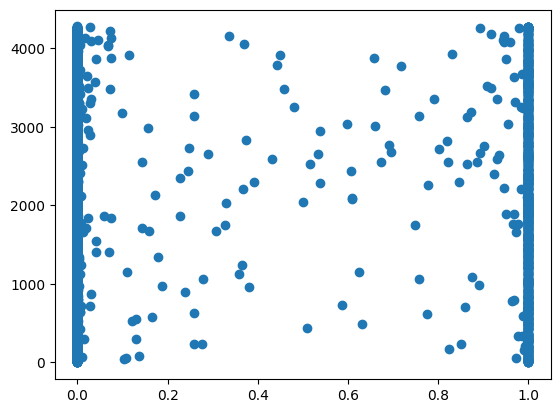

In [20]:
outputs = model.predict(samples)
plt.scatter(outputs, range(len(outputs)))
plt.show()

In [21]:
pred = ['True' if out >= 0.5 else 'False' for out in outputs.reshape((outputs.shape[0],))]

In [22]:
np.vstack([passenger_ids, pred]).T

array([['0013_01', 'False'],
       ['0018_01', 'False'],
       ['0019_01', 'False'],
       ...,
       ['9271_01', 'True'],
       ['9273_01', 'True'],
       ['9277_01', 'False']], dtype=object)

In [23]:
pd.DataFrame(np.vstack([passenger_ids, pred]).T, columns=['PassengerId', 'Transported']).to_csv('submission.csv', index=False)